# Fetch Codebase and Models

In [3]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/t74z87pk3cf8ny7/pggan_celebahq.pth?dl=1 -O models/pretrain/pggan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/nmo2g3u0qt7x70m/stylegan_celebahq.pth?dl=1 -O models/pretrain/stylegan_celebahq.pth --quiet
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 613 (delta 94), reused 92 (delta 92), pack-reused 489
Receiving objects: 100% (613/613), 13.71 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (204/204), done.


In [4]:
#@title Dev ops: mount google drive 
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/interfacegan


Mounted at /content/drive
/content/drive/MyDrive/interfacegan


In [17]:
#@title Dev ops: git 
!git add docs/
!git commit -m "feat: support WP"

On branch master
Your branch is up to date with 'origin/master'.

Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   docs/InterFaceGAN.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	shape_predictor_68_face_landmarks.dat
	shape_predictor_68_face_landmarks.dat.bz2
	utils/common.py



# Define Utility Functions

In [10]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models.model_settings import MODEL_POOL
from models.pggan_generator import PGGANGenerator
from models.stylegan_generator import StyleGANGenerator
from utils.manipulator import linear_interpolate

from google.colab import files

def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'pggan':
    generator = PGGANGenerator(model_name)
  elif gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [6]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq" #@param ['pggan_celebahq','stylegan_celebahq', 'stylegan_ffhq']
latent_space_type = "WP" #@param ['Z', 'W', 'WP']

generator = build_generator(model_name)

ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundary_name = f'{model_name}_{attr_name}'
  if generator.gan_type == 'stylegan' and latent_space_type == 'Z':
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_boundary.npy')
  else:
    boundaries[attr_name] = np.load(f'boundaries/{boundary_name}_w_boundary.npy')

[2022-07-16 09:36:53,229][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2022-07-16 09:36:59,564][INFO] Successfully loaded!
[2022-07-16 09:36:59,566][INFO]   `lod` of the loaded model is 0.0.


# Upload photo and crop

Saving 2.jpg to 2.jpg
User uploaded file "2.jpg" with length 60162 bytes


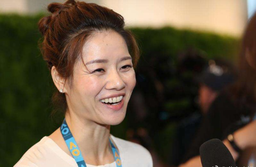

In [27]:
#@title #**Upload your photo** { display-mode: "form" }

os.makedirs('raw_images', exist_ok=True)

#@markdown Option 1. Upload a photo from computer (and leave the **url** blank)

#@markdown Option 2. Enter a link to the image

url = '' #@param {type:"string"}
if url == '':
  uploaded = files.upload()
  for fp in uploaded.keys():
    print('Upload file "{name}" with length {length} bytes'.format(
        name=fp, length=len(uploaded[fp])))
else:
  try:
    !wget $url
    fp = url.split('/')[-1]
  except BaseException:
    print("Something went wrong. Try uploading photos from your computer")

os.rename(fp, fp.replace(" ", ""))
fp = fp.replace(" ", "")
fn = 'photo.'+ fp.split('.')[-1]
!mv $fp raw_images/$fp
image_path = 'raw_images/'+fp

img1 = PIL.Image.open(image_path)
wpercent = (256/float(img1.size[0]))
hsize = int((float(img1.size[1])*float(wpercent)))
img1 = img1.resize((256,hsize), PIL.Image.LANCZOS)
display(img1)

Aligned image has shape: (256, 256)


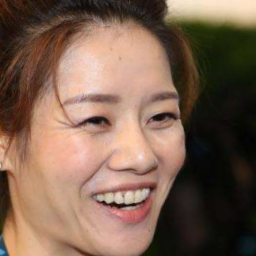

In [32]:
#@title #**Automatically align photo and crop**

#@markdown *Based on dlib landmarks detection*

if 'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

input_image = run_alignment(image_path)
resize_dims = (256, 256)
input_image.resize(resize_dims)

# Get photo latent codes (#TODO)

(1, 18, 512)


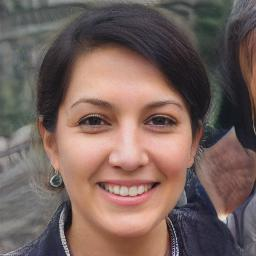

In [7]:
# # @title { display-mode: "form", run: "auto" }

# num_samples = 4 #@param {type:"slider", min:1, max:8, step:1}
# noise_seed = 0 #@param {type:"slider", min:0, max:1000, step:1}

# latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)

latent_codes = np.load('/content/0.npy')
# latent_codes = np.reshape(latent_code, (-1,18,512))
print(latent_codes.shape)

if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  synthesis_kwargs = {'latent_space_type': 'W'}
elif generator.gan_type == 'stylegan' and latent_space_type == 'WP':
  synthesis_kwargs = {'latent_space_type': 'WP'}
else:
  synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=1)

# Edit facial attributes

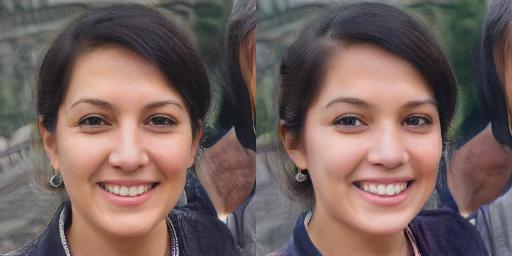

In [18]:
#@title { display-mode: "form", run: "auto" }

age = -0.6 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
eyeglasses = -0.5 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
gender = -0.2 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0.8 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0.5 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
cmp_images = np.concatenate((images, new_images), axis=0)
imshow(cmp_images, col=2)

In [19]:
#@title Save and compare
download_photo = True #@param {type:"boolean"}
file_name = 'myphoto' #@param {type:"string"}
file_type = ".jpg" #@param ['.jpg', '.png']
if file_name == '':
  file_name = fp

PIL.Image.fromarray(new_images[0]).save('generated_images/' + fp)
if download_photo == True:
  files.download('generated_images/' + file_name + file_type)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>